In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
WIN = 'D:/'
MAC = '/Volumes/Transcend2/'

osp = MAC

## Load aligned peaksets

In [5]:
all_df = pd.read_csv(osp+'/pymz/mzmine/221119/samples_alignment/pp_aligned.csv', index_col=0)
feature_description = all_df.iloc[:,:2]
all_samples = all_df.iloc[:,2:-1]
all_samples.columns = [x.split(" ")[0] for x in list(all_samples.columns)]

## Label samples

In [6]:
condition = []
dataset = []
for name in np.array(all_samples.columns):
    value = name.split('.')[0].split('_')[0][0]
    value2 = name.split('.')[0].split('_')[0][0]
    
    if (value == 'C' and len(name.split('.')[0].split('_')) == 2 and name.split('.')[0].split('_')[1] == '2'):
        condition.append('control')
        dataset.append('VL')
    elif  (value == 'C'):   
        condition.append('control')
        dataset.append('Zika')
    elif (value == 'Z'):
        condition.append('infected')
        dataset.append('Zika')
    elif (value[0] == 'V'):
        condition.append('infected')
        dataset.append('VL')
        
    elif (value == 'K' and int(name.split('.')[0].split('_')[1])%3 == 1 ):
        condition.append('control')
        dataset.append('Malaria')
    else:
        condition.append('infected')
        dataset.append('Malaria')
        

In [7]:
sample_description = pd.DataFrame(data=[list(all_samples.columns),condition,dataset] )
sample_description = sample_description.transpose()
sample_description.columns = ['Sample Name', 'Condition', 'Dataset']
sample_description["ConditionDataset"] = sample_description["Condition"]+sample_description["Dataset"]

## Log transformation

In [8]:
all_samples_log = np.log2(all_samples+1)
print('Total number of peaksets: {}'.format(len(all_samples_log)))

Total number of peaksets: 37220


In [ ]:
all_samples_log.plot.density(legend = False)

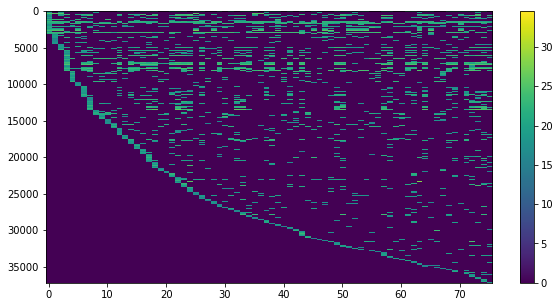

In [10]:
plt.figure(figsize=(10,5))
plt.imshow(all_samples_log,aspect='auto')
plt.colorbar()
plt.show()

## PCA plot

In [9]:
# rearranging the dataframe
Zik = all_samples_log.transpose()[np.array(sample_description['Dataset'] == 'Zika')].transpose()
zik_con = Zik.transpose()[np.array(sample_description[sample_description["Dataset"] == "Zika"]['Condition'] =="control")].transpose()
zik_inf = Zik.transpose()[np.array(sample_description[sample_description["Dataset"] == "Zika"]['Condition'] =="infected")].transpose()
Mal = all_samples_log.transpose()[np.array(sample_description['Dataset'] == 'Malaria')].transpose()
mal_con = Mal.transpose()[np.array(sample_description[sample_description["Dataset"] == "Malaria"]['Condition'] =="control")].transpose()
mal_inf = Mal.transpose()[np.array(sample_description[sample_description["Dataset"] == "Malaria"]['Condition'] =="infected")].transpose()
vl = all_samples_log.transpose()[np.array(sample_description['Dataset'] == 'VL')].transpose()
vl_con = vl.transpose()[np.array(sample_description[sample_description["Dataset"] == "VL"]['Condition'] =="control")].transpose()
vl_inf = vl.transpose()[np.array(sample_description[sample_description["Dataset"] == "VL"]['Condition'] =="infected")].transpose()

In [10]:
pdList = [vl_inf,vl_con,zik_inf, zik_con, mal_inf,mal_con]  
all_samples_log_rearanged = pd.concat(pdList, axis = 1)

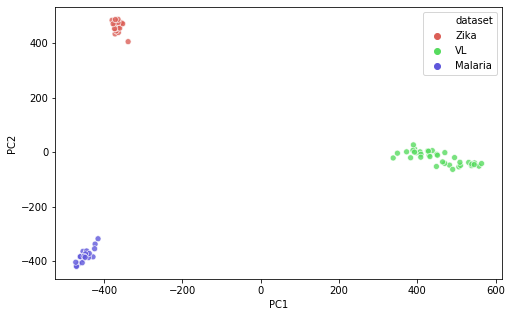

In [11]:
from sklearn.decomposition import PCA
pca_samples = PCA(n_components=3)

principalComponents = pca_samples.fit_transform(all_samples_log.transpose())
principalComponents_df = pd.DataFrame(data = principalComponents, columns= ['PC1','PC2', 'PC3'])
principalComponents_df['condition'] = list(sample_description['Condition'])
principalComponents_df['dataset'] = list(sample_description['Dataset'])

plt.figure(figsize=(8,5))
sns.scatterplot(x="PC1", y="PC2",hue="dataset",
    palette=sns.color_palette("hls", 3),
    data=principalComponents_df,
    legend="full",
    alpha=0.8
)

## Filtering

In [12]:
from metab_utils import get_ids_for_top_percent
idzik = get_ids_for_top_percent(Zik, 50)
idmal = get_ids_for_top_percent(Mal, 50)
idvl = get_ids_for_top_percent(vl, 50)
inters = set(idzik) & set(idmal) & set(idvl)
print('Total number of peaksets remaining after filtering: {}'.format(len(inters)))

Total number of peaksets remaining after filtering: 604


In [13]:
all_samples_log_filtered = all_samples_log.loc[list(inters)]

KeyboardInterrupt: 

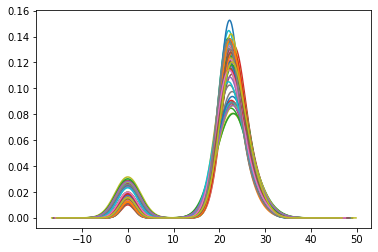

In [24]:
all_samples_log_filtered.plot.density(legend=False)

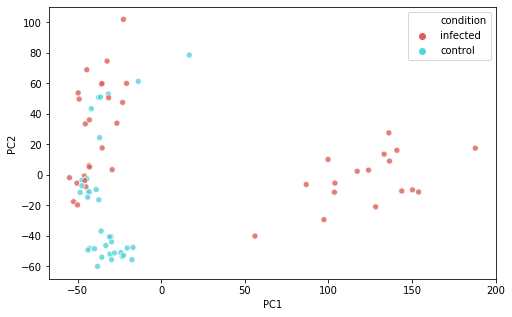

In [14]:
pca_samples = PCA(n_components=3)

principalComponents = pca_samples.fit_transform(all_samples_log_filtered.transpose())
principalComponents_df = pd.DataFrame(data = principalComponents, columns= ['PC1','PC2', 'PC3'])
principalComponents_df['condition'] = list(sample_description['Condition'])
principalComponents_df['dataset'] = list(sample_description['Dataset'])

plt.figure(figsize=(8,5))
sns.scatterplot(x="PC1", y="PC2",hue="condition",
    palette=sns.color_palette("hls", 2),
    data=principalComponents_df,
    legend="full",
    alpha=0.8
)

## Imputing missing values with KNN

In [15]:
all_samples_log_filtered_na = all_samples_log_filtered.copy()
all_samples_log_filtered_na.replace(0, np.nan, inplace = True)

In [16]:
from metab_utils import impute_knn
sample_values = all_samples_log_filtered_na
zik_con_filled = impute_knn(sample_values, list(zik_con.columns))
zik_inf_filled = impute_knn(sample_values, list(zik_inf.columns))
vl_con_filled = impute_knn(sample_values, list(vl_con.columns))
vl_inf_filled = impute_knn(sample_values, list(vl_inf.columns))
mal_con_filled = impute_knn(sample_values, list(mal_con.columns))
mal_inf_filled = impute_knn(sample_values, list(mal_inf.columns))

Using TensorFlow backend.


Imputing row 1/604 with 0 missing, elapsed time: 0.076
Imputing row 101/604 with 0 missing, elapsed time: 0.077
Imputing row 201/604 with 0 missing, elapsed time: 0.079
Imputing row 301/604 with 0 missing, elapsed time: 0.081
Imputing row 401/604 with 0 missing, elapsed time: 0.083
Imputing row 501/604 with 2 missing, elapsed time: 0.084
Imputing row 601/604 with 3 missing, elapsed time: 0.086
Imputing row 1/604 with 0 missing, elapsed time: 0.070
Imputing row 101/604 with 0 missing, elapsed time: 0.072
Imputing row 201/604 with 0 missing, elapsed time: 0.074
Imputing row 301/604 with 0 missing, elapsed time: 0.077
Imputing row 401/604 with 0 missing, elapsed time: 0.078
Imputing row 501/604 with 2 missing, elapsed time: 0.080
Imputing row 601/604 with 2 missing, elapsed time: 0.082
Imputing row 1/604 with 0 missing, elapsed time: 0.086
Imputing row 101/604 with 0 missing, elapsed time: 0.089
Imputing row 201/604 with 0 missing, elapsed time: 0.092
Imputing row 301/604 with 0 missing, 

In [17]:
pdList = [vl_inf_filled,vl_con_filled,zik_inf_filled, zik_con_filled, mal_inf_filled,mal_con_filled]  
all_samples_log_filtered_filled = pd.concat(pdList, axis = 1)
all_samples_log_filtered_filled = all_samples_log_filtered_filled[list(all_samples_log.columns)]

## Export data

In [18]:
#filtered values without missing values imputed
all_samples_log_filtered.to_csv(osp+'pymz/mzmine/221119/all_samples_log2_filtered.csv', header=True, index=True, sep=',', mode='w')
#filtered values with missing values imputed
all_samples_log_filtered_filled.to_csv(osp+'pymz/mzmine/221119/all_samples_log2_filtered_filled.csv', header=True, index=True, sep=',', mode='w')
#pheno data
sample_description.to_csv(osp+'pymz/mzmine/221119/sample_description.csv', header=True, index=None, sep=',', mode='w')
feature_description.to_csv(osp+'pymz/mzmine/221119/feature_description.csv', header=True, index=True, sep=',', mode='w')
                           
                           

In [20]:
filtered_samples = all_samples_log_filtered.copy()
filtered_samples = filtered_samples.transpose()
filtered_samples["Condition"] = np.array(sample_description["Condition"])
filtered_samples["Dataset"] = np.array(sample_description["Dataset"])
filtered_samples['ConditionDataset'] = np.array(sample_description['ConditionDataset'])
filtered_samples.to_csv(osp+'pymz/mzmine/221119/modifiedRTfiltereddata.txt', header=True, index=True, sep='\t', mode='w')